In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img,save_img

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [3]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
def define_encoder_block(layer_in,n_filters,batchnorm=True):
    
    init=RandomNormal(stddev=0.02,seed=1)

    g=Conv2D(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    if batchnorm:
        g=BatchNormalization()(g,training=True)
    g=LeakyReLU(alpha=0.2)(g)
    
    return g

In [5]:
def define_decoder_block(layer_in,skip_in,n_filters,dropout=True):
    
    init=RandomNormal(stddev=0.02,seed=1)

    g=Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    g=BatchNormalization()(g,training=True)
    if dropout:
        g=Dropout(0.5)(g,training=True)
    g=Concatenate()([g,skip_in])
    g=Activation('relu')(g)

    return g

In [6]:
def define_generator(image_shape=(256,256,3)):

    init=RandomNormal(stddev=0.02,seed=1)

    in_image=Input(shape=image_shape)

    e1=define_encoder_block(in_image,64,batchnorm=False)
    e2=define_encoder_block(e1,128)
    e3=define_encoder_block(e2,256)
    e4=define_encoder_block(e3,512)
    e5=define_encoder_block(e4,512)
    e6=define_encoder_block(e5,512)
    e7=define_encoder_block(e6,512)

    b=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    b=Activation('relu')(b)

    d1=define_decoder_block(b,e7,512)
    d2=define_decoder_block(d1,e6,512)
    d3=define_decoder_block(d2,e5,512)
    d4=define_decoder_block(d3,e4,512,dropout=False)
    d5=define_decoder_block(d4,e3,256,dropout=False)
    d6=define_decoder_block(d5,e2,128,dropout=False)
    d7=define_decoder_block(d6,e1,64,dropout=False)

    g=Conv2DTranspose(image_shape[2],(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
    out_image=Activation('tanh')(g)

    model=Model(in_image,out_image)
    return model

In [7]:
g_model=define_generator()

In [8]:
g_model.load_weights(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\gan_results\g_models\g_model_052000.h5")

In [9]:
color=[
    np.array([0,195,255]),
    np.array([0,15,255]),
    np.array([255,155,0]),
    np.array([255,0,245]),
    np.array([0,115,25]),
    np.array([255,200,215]),
    np.array([185,100,255]),
    np.array([195,180,255]),
    np.array([190,245,95]),
    np.array([0,255,45]),
    np.array([115,255,215]),
    np.array([180,110,50]),
    np.array([200,235,255]),
    np.array([255,255,255]),
    np.array([0,0,0]),
    np.array([255,0,0]),
    np.array([0,0,0]),
    np.array([255,255,0])
]

def post_processing_get_values(img):
    output_img=img
    for i in range(0,18):
        filtered_img_green=img[:,:,1]==i
        output_img=output_img*(np.reshape(filtered_img_green==0,(256,256,1)))+(np.reshape(filtered_img_green,(256,256,1))*color[i])
    return output_img

In [10]:
for i in range(60035,80788):
    path=f"./dataset/floorplan_dataset/{i}.png"
    in_path=f"./processed_dataset/image_gan_in_final/{i}.png"
    dest_path_in=f"./processed_dataset/image_post_processing_in/{i}.png"
    dest_path_out=f"./processed_dataset/image_post_processing_out/{i}.png"
    img=np.array(load_img(path))
    in_img=(np.array(load_img(in_path))/255.0).reshape((1,256,256,3))
    input_img=g_model.predict(in_img,verbose=0)
    input_img=input_img[0]
    output_img=post_processing_get_values(img)
    save_img(dest_path_in,input_img)
    save_img(dest_path_out,output_img)    

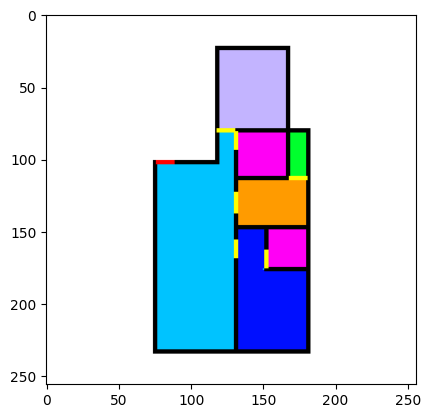

In [22]:
dest_path_out=f"./processed_dataset/image_post_processing_out/{9}.png"
output_img=np.array(load_img(dest_path_out))
plt.imshow(output_img)

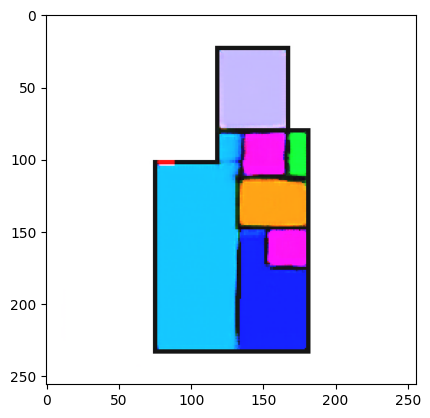

In [23]:
dest_path_in=f"./processed_dataset/image_post_processing_in/{9}.png"
input_img=np.array(load_img(dest_path_in))
plt.imshow(input_img)